In [1]:
from pytket.circuit import Circuit
from pytket.circuit.display import render_circuit_jupyter

In [2]:
from pytket.extensions.qiskit import AerBackend
from pytket.backends.backendresult import BackendResult
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from pytket.circuit import QControlBox, CircBox, StatePreparationBox
from pytket.backends.backendresult import BackendResult
from pytket.utils import QubitPauliOperator, gen_term_sequence_circuit
from pytket import Qubit, Circuit
from pytket.passes import DecomposeBoxes
from pytket.circuit.display import render_circuit_jupyter
from pytket.pauli import Pauli, QubitPauliString

In [19]:
def build_u_t_approximation() -> Circuit:
    # t is pi/2
    # 1 Trotter step
    
    z1 = QubitPauliString({Qubit(0):Pauli.Z})
    z2 = QubitPauliString({Qubit(1):Pauli.Z})
    I =  QubitPauliString({Qubit(0):Pauli.I, Qubit(1):Pauli.I})
    zz = QubitPauliString({Qubit(0):Pauli.Z, Qubit(1):Pauli.Z})
    yy = QubitPauliString({Qubit(0):Pauli.Y, Qubit(1):Pauli.Y})

    H = QubitPauliOperator({z1: -0.3980, z2: - 0.3980, yy: - 0.1809, zz:0.0112, I:-0.3322})

    circ = gen_term_sequence_circuit(H, Circuit(2))
        
    return circ

In [20]:
def build_qft_circuit(n_qubits: int) -> Circuit:
    circ = Circuit(n_qubits, name="QFT")
    for i in range(n_qubits):
        circ.H(i)
        for j in range(i + 1, n_qubits):
            circ.CU1(1 / 2 ** (j - i), j, i)
    for k in range(0, n_qubits // 2):
        circ.SWAP(k, n_qubits - k - 1)
    return circ

In [21]:
def build_phase_estimation_circuit(
    n_measurement_qubits: int, state_prep_circuit: Circuit, unitary_circuit: Circuit
) -> Circuit:
    # Define a Circuit with a measurement and prep register
    qpe_circ: Circuit = Circuit()
    n_state_prep_qubits = state_prep_circuit.n_qubits
    measurement_register = qpe_circ.add_q_register("m", n_measurement_qubits)
    state_prep_register = qpe_circ.add_q_register("p", n_state_prep_qubits)
    qpe_circ.add_circuit(state_prep_circuit, list(state_prep_register))

    # Create a controlled unitary with a single control qubit
    unitary_circuit.name = "U"
    controlled_u_gate = QControlBox(CircBox(unitary_circuit), 1)

    # Add Hadamard gates to every qubit in the measurement register
    for m_qubit in measurement_register:
        qpe_circ.H(m_qubit)

    # Add all (2**n_measurement_qubits - 1) of the controlled unitaries sequentially
    for m_qubit in range(n_measurement_qubits):
        control_index = n_measurement_qubits - m_qubit - 1
        control_qubit = [measurement_register[control_index]]
        for _ in range(2**m_qubit):
            qpe_circ.add_qcontrolbox(
                controlled_u_gate, control_qubit + list(state_prep_register)
            )

    # Finally, append the inverse qft and measure the qubits
    qft_box = CircBox(build_qft_circuit(n_measurement_qubits))
    inverse_qft_box = qft_box.dagger
    qpe_circ.add_circbox(inverse_qft_box, list(measurement_register))
    qpe_circ.measure_register(measurement_register, "c")
    return qpe_circ

In [50]:
# prepare the  eigenstate of U(t)
prep_circuit = Circuit(2)
U= StatePreparationBox(np.array([.11150103564, 0,0, .99376431765])) #most excited eigenstate
#U = StatePreparationBox(np.array([ -.99376431765,0,0,.11150103564])) #ground eigenstate
prep_circuit.add_state_preparation_box(U, [0,1])


 # Base unitary for controlled U ops
unitary_circuit = build_u_t_approximation()
qpe_circ = build_phase_estimation_circuit(
    7, state_prep_circuit=prep_circuit, unitary_circuit=unitary_circuit
)
render_circuit_jupyter(qpe_circ)

In [51]:
backend = AerBackend()
compiled_circ = backend.get_compiled_circuit(qpe_circ)
n_shots = 100
result = backend.run_circuit(compiled_circ, n_shots)
print(result.get_counts())

Counter({(1, 1, 1, 0, 0, 0, 0): 50, (1, 1, 1, 0, 0, 0, 1): 26, (1, 1, 1, 0, 0, 1, 0): 5, (1, 1, 0, 1, 1, 1, 1): 4, (0, 1, 0, 0, 1, 0, 0): 3, (1, 1, 1, 0, 0, 1, 1): 3, (0, 0, 0, 0, 0, 0, 0): 1, (0, 1, 0, 0, 0, 1, 1): 1, (1, 0, 0, 1, 0, 1, 0): 1, (1, 1, 0, 0, 1, 0, 1): 1, (1, 1, 0, 1, 1, 0, 0): 1, (1, 1, 0, 1, 1, 0, 1): 1, (1, 1, 0, 1, 1, 1, 0): 1, (1, 1, 1, 0, 1, 0, 0): 1, (1, 1, 1, 1, 0, 0, 1): 1})


In [52]:
def plot_qpe_results(
    sim_result: BackendResult,
    n_strings: int = 4,
    dark_mode: bool = False,
    y_limit: int = 1000,
) -> None:
    """
    Plots results in a barchart given a BackendResult. the number of stings displayed
    can be specified with the n_strings argument.
    """
    counts_dict = sim_result.get_counts()
    sorted_shots = counts_dict.most_common()
    n_most_common_strings = sorted_shots[:n_strings]
    x_axis_values = [str(entry[0]) for entry in n_most_common_strings]  # basis states
    y_axis_values = [entry[1] for entry in n_most_common_strings]  # counts
    if dark_mode:
        plt.style.use("dark_background")
    fig = plt.figure()
    ax = fig.add_axes((0, 0, 0.75, 0.5))
    color_list = ["orange"] * (len(x_axis_values))
    ax.bar(
        x=x_axis_values,
        height=y_axis_values,
        color=color_list,
    )
    ax.set_title(label="Results")
    plt.ylim([0, y_limit])
    plt.xlabel("Basis State")
    plt.ylabel("Number of Shots")
    plt.show()

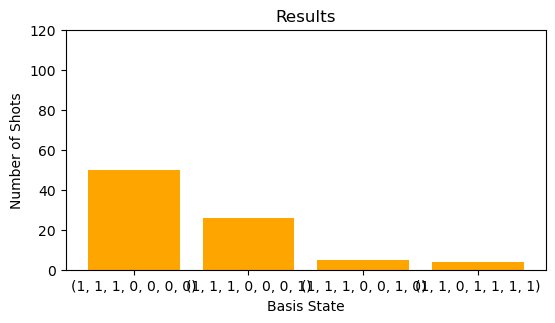

In [53]:
plot_qpe_results(result, y_limit=int(1.2 * n_shots))

In [54]:
def single_phase_from_backendresult(result: BackendResult) -> float:
    # Extract most common measurement outcome
    basis_state = result.get_counts().most_common()[0][0]
    bitstring = "".join([str(bit) for bit in basis_state])
    integer_j = int(bitstring, 2)

    # Calculate theta estimate
    return integer_j / (2 ** len(bitstring))

In [59]:
theta = single_phase_from_backendresult(result)
print(theta)

print (theta * -4) # have to divide by the time = pi/2, have to multiply by a factor of -2*pi as well, to get the energy. E = -phi*t

# ends up being necessary to multiply by a factor of -4.

0.875
-3.5


Exact E_0= -1.1375 E_h


Since the phase obtained from QPE is related to the eigenvalue $E$ of the Hamiltonian $H$ by the relation $ E = \frac{\phi}{t} \times \frac{1}{2\pi} $, and given that $t = 2\pi$, the estimated eigenvalue $E$ is simply $0.0625$ in the SI units.

This estimated energy can then be compared with known theoretical and experimental values to assess the accuracy of your quantum simulation. In practice, this simulation value is a raw estimate and further calculations, such as error mitigation or more sophisticated algorithms, may be necessary for precise results.cise results.

We get $$H=c_1Z + c_2X$$

So

$$U(t)=e^{iHt}= e^{i\left(c_1 Z+c_2 X\right) t}$$




In theory, a quantum computer is capable of implementing a general unitary operation, however the number of gates required to do so may be extremely large. In practice, a finite set of basis gates is defined, from which all other unitary operations are constructed. These basis gates ultimately correspond to operations that are performed on the physical qubits. On current quantum computers, such as a superconducting quantum processor, a common set of native operations might include Pauli rotation gates, $R_P(\theta)=e^{-i(\theta / 2) P}$, and a CZ (controlled Z) gate. For fault-tolerant quantum computers, arbitrary rotation gates cannot be protected, and one might instead work with the Hadamard gate, the phase gates $S$ and $T$, and the CNOT gate. However, in both cases, complex multi-qubit operations such as $e^{i H t}$, for a general $H$, cannot be performed directly.

The most common solution to approximately implement $U=e^{i H t}$ for $H$ as in Eq. 101 is through Trotter product formulas, or Trotterization. The simplest of these is the first-order

Trotter expansion
$$
e^{i H t} \approx U_1(t)=\prod_{j=1}^L e^{i H_j t} .
$$

The second-order Trotter expansion is defined by
$$
e^{i H t} \approx U_2(t)=\prod_{j=1}^L e^{i H_j t / 2} \prod_{j=L}^1 e^{i H_j t / 2} .
$$

The benefit of these expansions is that each term $e^{i H_j t}$ can now be implemented in a fairly direct manner on a quantum computer. However, these product formula are approximate, unless all the terms in $H$ commute with each other. In particular, the error on the $p^{\prime}$ th-order Trotter expansion is ${ }^{22}$
$$
\left\|U_p(t)-e^{i H t}\right\|=\mathcal{O}\left(\alpha t^{p+1}\right) .
$$

This means that the error in the first-order expansion is $\mathcal{O}\left(t^2\right)$, while the error in the secondorder expansion is $\mathcal{O}\left(t^3\right)$. The value $\alpha$ depends on the commutator of the terms in the partitioning of $H$.

In order to manage this error, we split the time evolution operator into $m$ steps, each of length $t / m$ :
$$
e^{i \sum_l H_l t}=\left(e^{i \sum_l H_l t / m}\right)^m .
$$

Each of the steps is then approximated by a Trotter formula, $U_p(t / m)$, which will become exact in the large- $m$ limit.



Now we show how to implement the time evolution operator $ U(t) $ for the H2 molecule using a first-order Trotter expansion. The goal is to approximate the continuous time evolution with a series of discrete steps that can be simulated on a quantum computer.

 , the time evolution operator $ U(t) $ is approximated by:

$$
U(t) \approx \left( e^{i c_1 Z t/m} e^{i c_2 X t/m} \right)^m
$$This is then further simplified using Pauli rotation gates, where the Pauli-Z rotation is defined as $R_Z(\theta)= e^{-i \theta Z/2}$ and the Pauli-X rotation as $R_X(\theta)=e^{-i \theta X/2}$. Therefore, for each term in the product, the approximation becomes:

$$
U(t) \approx \left( R_Z\left(-\frac{2c_1t}{m}\right) R_X\left(-\frac{2c_2t}{m}\right) \right)^m
$$ that as well.

In [152]:
z1 = QubitPauliString({Qubit(0):Pauli.Z})
z2 = QubitPauliString({Qubit(1):Pauli.Z})
I =  QubitPauliString({Qubit(1):Pauli.I})
zz = QubitPauliString({Qubit(0):Pauli.Z, Qubit(1):Pauli.Z})
yy = QubitPauliString({Qubit(0):Pauli.X, Qubit(1):Pauli.X})
H = QubitPauliOperator({z1: 0.1, z2: 0.3, zz: 0.6, yy:0.3, I: 0.4})
circ = gen_term_sequence_circuit(H, Circuit(2))
DecomposeBoxes().apply(circ)
render_circuit_jupyter(circ)